# BestOf Metric Example

This notebook demonstrates how to use the **BestOf** metric from Fair Forge to run tournament-style comparisons between multiple AI assistants.

The metric:
- Pairs up assistants in elimination rounds
- Uses an LLM judge to evaluate each matchup
- Advances winners until a final champion is determined
- Handles ties (both advance) and byes (odd number of contestants)

## Installation

First, install Fair Forge and the required dependencies.

In [ ]:
import sys
!uv pip install --python {sys.executable} --force-reinstall "$(ls ../../dist/*.whl)[bestof]" langchain-groq matplotlib -q

Using Python 3.11.11 environment at: /Users/alexfiorenza/.pyenv/versions/3.11.11
Resolved 44 packages in 272ms                                        
Prepared 44 packages in 3ms                                              
Uninstalled 44 packages in 426ms
Installed 44 packages in 105ms                              
 ~ alquimia-fair-forge==0.1.1 (from file:///Users/alexfiorenza/Documents/software_development/projects/alquimia/fair-forge/dist/alquimia_fair_forge-0.1.1-py3-none-any.whl)
 ~ annotated-types==0.7.0
 ~ anyio==4.12.1
 ~ certifi==2026.1.4
 ~ charset-normalizer==3.4.4
 ~ distro==1.9.0
 ~ filelock==3.20.3
 ~ fsspec==2026.1.0
 ~ groq==0.37.1
 ~ h11==0.16.0
 ~ hf-xet==1.2.0
 ~ httpcore==1.0.9
 ~ httpx==0.28.1
 ~ huggingface-hub==0.36.0
 ~ idna==3.11
 ~ jinja2==3.1.6
 ~ jsonpatch==1.33
 ~ jsonpointer==3.0.0
 ~ langchain-core==0.3.82
 ~ langchain-groq==0.3.8
 ~ langsmith==0.6.2
 ~ loguru==0.7.3
 ~ markupsafe==3.0.3
 - numpy==2.3.5
 + numpy==2.4.1
 ~ orjson==3.11.5
 ~ packaging==25.

## Setup

Import the required modules and configure your API key.

In [2]:
import os
import sys
import json
from pathlib import Path

sys.path.insert(0, os.path.dirname(os.getcwd()))

from fair_forge.metrics.best_of import BestOf
from fair_forge import Retriever
from fair_forge.schemas import Dataset
from langchain_groq import ChatGroq

/Users/alexfiorenza/.pyenv/versions/3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import getpass

GROQ_API_KEY = getpass.getpass("Enter your Groq API key: ")

## Create a Multi-Assistant Retriever

The BestOf metric requires datasets with multiple `assistant_id` values to compare. We'll use a custom dataset with 4 assistants of varying quality.

In [4]:
class BestOfRetriever(Retriever):
    """Retriever that loads the multi-assistant dataset for BestOf comparison."""

    def load_dataset(self) -> list[Dataset]:
        dataset_path = Path("dataset_bestof.json")
        datasets = []
        with open(dataset_path) as infile:
            for dataset in json.load(infile):
                datasets.append(Dataset.model_validate(dataset))
        return datasets

## Preview the Dataset

Let's see which assistants we'll be comparing.

In [5]:
retriever = BestOfRetriever()
datasets = retriever.load_dataset()

print(f"Number of assistants: {len(datasets)}")
print(f"\nAssistants in tournament:")
for ds in datasets:
    print(f"  - {ds.assistant_id}: {len(ds.conversation)} conversations")
    
print(f"\nSample question: {datasets[0].conversation[0].query}")
print(f"\nResponses from each assistant:")
for ds in datasets:
    print(f"\n{ds.assistant_id}:")
    print(f"  {ds.conversation[0].assistant[:100]}...")

Number of assistants: 4

Assistants in tournament:
  - assistant_alpha: 3 conversations
  - assistant_beta: 3 conversations
  - assistant_gamma: 3 conversations
  - assistant_delta: 3 conversations

Sample question: What are the benefits of renewable energy?

Responses from each assistant:

assistant_alpha:
  Renewable energy offers numerous benefits including reduced greenhouse gas emissions, decreased air ...

assistant_beta:
  Renewable energy is good because it doesn't pollute as much. Solar panels and wind turbines can gene...

assistant_gamma:
  The transition to renewable energy represents one of the most significant technological and economic...

assistant_delta:
  Clean energy good. Sun power, wind power, water power all help planet. No smoke, no bad air....


## Initialize the Judge Model

The BestOf metric uses an LLM as a judge to compare pairs of assistants.

In [6]:
judge_model = ChatGroq(
    model="qwen/qwen3-32b",
    api_key=GROQ_API_KEY,
    temperature=0.0,
)

## Run the Tournament

The BestOf metric will run elimination rounds until one assistant is crowned the winner.

In [7]:
metrics = BestOf.run(
    BestOfRetriever,
    model=judge_model,
    use_structured_output=True,
    criteria="Overall response quality, helpfulness, and clarity",
    verbose=True,
)

2026-01-12 20:51:40,598 - fair_forge.utils.logging - INFO - Loaded dataset with 4 batches
2026-01-12 20:51:40,599 - fair_forge.utils.logging - INFO - [BestOf] Aggregating datasets by query for best-of comparisons
2026-01-12 20:51:40,599 - fair_forge.utils.logging - INFO - [BestOf] Round 1: 4 contestants remaining
2026-01-12 20:51:40,599 - fair_forge.utils.logging - INFO - [BestOf] Round 1: Comparing 2 pairs
2026-01-12 20:51:40,604 - fair_forge.utils.logging - DEBUG - Round 1: Comparing assistant_alpha and assistant_beta contestants
2026-01-12 20:51:42,411 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-12 20:51:42,433 - fair_forge.utils.logging - DEBUG - Round 1: Winner is assistant_alpha
2026-01-12 20:51:42,435 - fair_forge.utils.logging - DEBUG - Round 1: Comparing assistant_delta and assistant_gamma contestants
2026-01-12 20:51:44,034 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTT

## Analyze Tournament Results

In [8]:
tournament = metrics[0]

print(f"Tournament Winner: {tournament.bestof_winner_id}")
print(f"\nTotal Contests: {len(tournament.bestof_contests)}")
print("\n" + "=" * 60)

rounds = {}
for contest in tournament.bestof_contests:
    if contest.round not in rounds:
        rounds[contest.round] = []
    rounds[contest.round].append(contest)

for round_num in sorted(rounds.keys()):
    print(f"\nRound {round_num}:")
    print("-" * 40)
    for contest in rounds[round_num]:
        print(f"  {contest.left_id} vs {contest.right_id}")
        print(f"    Winner: {contest.winner_id}")
        print(f"    Confidence: {contest.confidence}")
        print(f"    Verdict: {contest.verdict}")
        print()

Tournament Winner: assistant_gamma

Total Contests: 3


Round 1:
----------------------------------------
  assistant_alpha vs assistant_beta
    Winner: assistant_alpha
    Confidence: 0.95
    Verdict: Assistant_alpha provides more accurate, complete, and structured responses across all queries. It addresses key points thoroughly, uses clear explanations, and aligns closely with expected answers. Assistant_beta's responses are concise but lack depth, miss critical details (e.g., cost savings in renewable energy), and sometimes oversimplify concepts (e.g., describing ML as 'statistics with more computing power').

  assistant_delta vs assistant_gamma
    Winner: assistant_gamma
    Confidence: 0.95
    Verdict: Assistant Gamma provides more comprehensive, structured, and detailed responses across all queries. Their answers align closely with the expected answers while adding depth and context, demonstrating superior clarity, completeness, and relevance. Delta's responses are accurate 

## Visualize the Tournament Bracket

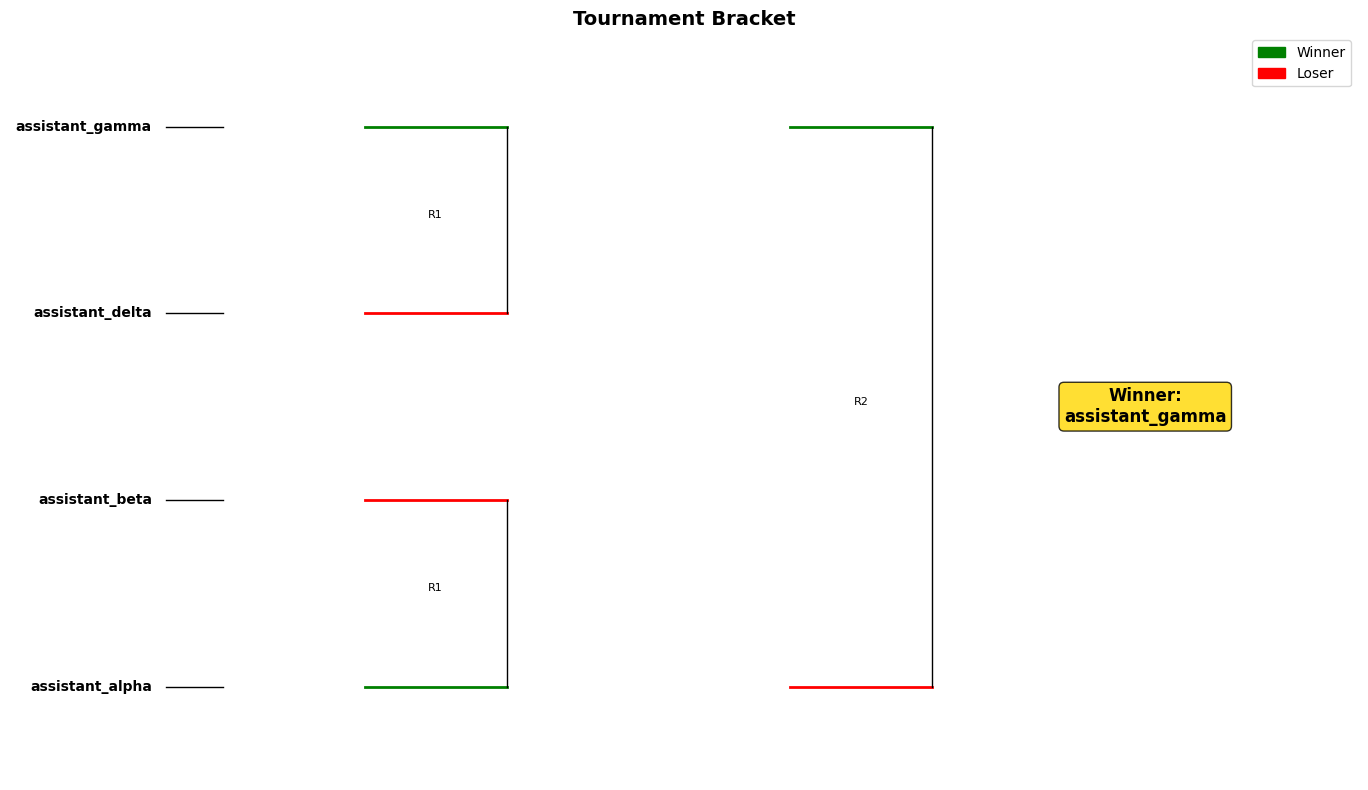

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 8))

num_rounds = max(c.round for c in tournament.bestof_contests)
contestants = sorted({ds.assistant_id for ds in datasets})

round_x = {}
for r in range(1, num_rounds + 2):
    round_x[r] = r * 3

y_positions = {}
for i, contestant in enumerate(contestants):
    y_positions[contestant] = (i + 0.5) * 2

for i, contestant in enumerate(contestants):
    ax.text(0.5, y_positions[contestant], contestant, 
            ha='right', va='center', fontsize=10, fontweight='bold')
    ax.plot([0.6, 1], [y_positions[contestant], y_positions[contestant]], 'k-', linewidth=1)

colors = {'winner': 'green', 'loser': 'red', 'tie': 'orange'}

for contest in tournament.bestof_contests:
    x = round_x[contest.round]
    y1 = y_positions[contest.left_id]
    y2 = y_positions[contest.right_id]
    y_mid = (y1 + y2) / 2
    
    left_color = colors['winner'] if contest.winner_id == contest.left_id else colors['loser']
    right_color = colors['winner'] if contest.winner_id == contest.right_id else colors['loser']
    
    ax.plot([x-1, x], [y1, y1], color=left_color, linewidth=2)
    ax.plot([x-1, x], [y2, y2], color=right_color, linewidth=2)
    ax.plot([x, x], [y1, y2], 'k-', linewidth=1)
    
    ax.annotate(f'R{contest.round}', (x-0.5, y_mid), ha='center', va='bottom', fontsize=8)

ax.text(round_x[num_rounds] + 1.5, sum(y_positions.values())/len(y_positions), 
        f"Winner:\n{tournament.bestof_winner_id}", 
        ha='center', va='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='gold', alpha=0.8))

ax.set_xlim(-0.5, round_x[num_rounds] + 3)
ax.set_ylim(0, max(y_positions.values()) + 1)
ax.axis('off')
ax.set_title('Tournament Bracket', fontsize=14, fontweight='bold')

winner_patch = mpatches.Patch(color='green', label='Winner')
loser_patch = mpatches.Patch(color='red', label='Loser')
ax.legend(handles=[winner_patch, loser_patch], loc='upper right')

plt.tight_layout()
plt.show()

## Review Judge Reasoning

Let's examine the judge's reasoning for each matchup.

In [10]:
for contest in tournament.bestof_contests:
    print(f"\n{'='*60}")
    print(f"Round {contest.round}: {contest.left_id} vs {contest.right_id}")
    print(f"{'='*60}")
    print(f"\nWinner: {contest.winner_id}")
    print(f"Confidence: {contest.confidence}")
    print(f"\nVerdict: {contest.verdict}")
    print(f"\nReasoning: {contest.reasoning}")


Round 1: assistant_alpha vs assistant_beta

Winner: assistant_alpha
Confidence: 0.95

Verdict: Assistant_alpha provides more accurate, complete, and structured responses across all queries. It addresses key points thoroughly, uses clear explanations, and aligns closely with expected answers. Assistant_beta's responses are concise but lack depth, miss critical details (e.g., cost savings in renewable energy), and sometimes oversimplify concepts (e.g., describing ML as 'statistics with more computing power').

Reasoning: {'assistant_alpha': {'strengths': ['Comprehensive coverage of key points', 'Clear and structured explanations', 'Includes relevant examples (e.g., solar/wind in renewable energy)'], 'weaknesses': []}, 'assistant_beta': {'strengths': ['Concise answers', 'Addresses basic requirements'], 'weaknesses': ['Incomplete responses (e.g., misses cost savings in renewable energy)', "Simplistic explanations (e.g., ML as 'statistics')", 'Less alignment with expected answers']}}

Roun

## Understanding the Results

### Tournament Structure

- **Round 1**: Initial pairings (4 assistants → 2 winners)
- **Round 2**: Finals (2 assistants → 1 champion)

### Contest Output

Each contest provides:
- `winner_id`: The assistant that won this matchup
- `confidence`: Judge's confidence in the decision
- `verdict`: Brief summary of why this assistant won
- `reasoning`: Detailed analysis of both assistants' performance

### Special Cases

- **Ties**: Both assistants advance to the next round
- **Byes**: With odd contestants, one gets a free pass to the next round

### Use Cases

- **Model Selection**: Compare multiple LLMs to find the best for your use case
- **A/B Testing**: Evaluate different prompt strategies or configurations
- **Quality Benchmarking**: Establish baseline quality across assistant versions